In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import Loss
import time 
# from tensorflow.keras.applications import *
# from matplotlib import plotly as plt
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE
import pickle
from sklearn.decomposition import PCA

In [3]:
plt.rcParams['figure.figsize'] = [12, 8]


(30000, 56, 28)
(30000, 2)
(5000, 56, 28, 1)
(5000, 2)
(56, 28, 1)


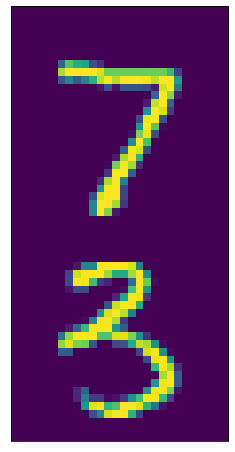

tf.Tensor(
[[7. 3.]
 [2. 9.]
 [1. 9.]
 ...
 [2. 4.]
 [4. 5.]
 [0. 6.]], shape=(5000, 2), dtype=float32)


In [17]:
batch_size = 32
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

N = x_train.shape[0] // 2
x_train = np.concatenate((x_train[:N], x_train[N:]), axis=1)
y_train = np.stack((y_train[:N], y_train[N:]), axis=1)
# y_train = tf.ones(y_train.shape)
N = x_test.shape[0] // 2

x_test = np.concatenate((x_test[:N], x_test[N:]), axis=1)
y_test = np.stack((y_test[:N], y_test[N:]), axis=1)
# y_test = tf.ones(y_test.shape)
print(x_train.shape)
print(y_train.shape)



input_shape = x_train[0].shape

x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

x_test = tf.expand_dims(x_test, -1)
x_train = tf.expand_dims(x_train, -1)
print(x_test.shape)
print(y_test.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size)

input_shape = x_test[0].shape
num_classes = 10
print(input_shape)

plt.figure()
plt.imshow(x_test[0, :, :, 0]) 
plt.xticks([])
plt.yticks([])
plt.savefig('input_image.png')

plt.show()
print(y_test)



In [5]:
(x_same, _), (_, _) = tf.keras.datasets.mnist.load_data()

x_same = np.concatenate((x_same[:N], x_same[:N]), axis=1)
print(x_same.shape)

(5000, 56, 28)


In [6]:

kernel_size = (3, 3 )

dilation_rate = 1

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        # layers.Conv2D(32, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same", activation="relu"),
        layers.Conv2D(16, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(8, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(4, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(2, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same", activation="relu"),
        # layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(20, activation="relu"),
        layers.Dense(2*num_classes, activation=None),
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 7, 8)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 7, 4)          292       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 3, 4)          0

In [36]:
kernel_size = (3, 3)

dilation_rate = 1

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(32, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(50, activation="relu"),
        layers.Dense(2*num_classes, activation=None),
    ]
)

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 56, 28, 64)        640       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 28, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 14, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 14, 7, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 14, 7, 32)         18464     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 7, 3, 32)        

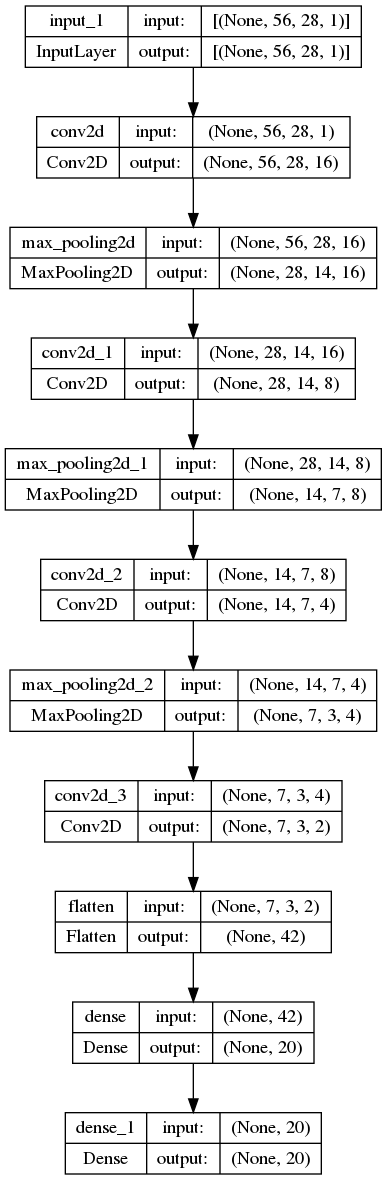

In [7]:
from keras.utils import plot_model 

plot_model(model, to_file='small_cnn.png', show_shapes=True, show_layer_names=True)

In [37]:

optimizer = tf.keras.optimizers.Adam(0.001)

cce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# loss_fn = cce_loss
def loss_fn(y, y_hat): 
#     print(y[:, 0], y_hat[:, :10])
    return cce_loss(y[:, 0], y_hat[:, :10]) + cce_loss(y[:, 1], y_hat[:, 10:])

#         cce_loss(y_batch_train[:, 0], logits[:, :10]) + cce_loss(y_batch_train[:, 0], logits[:, 10:])


model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=loss_fn
)

model.fit(
    train_dataset,
    epochs=6,
    validation_data=test_dataset,
)
# !mkdir -p saved_model

# model.save('saved_model/my_model')


Epoch 1/6
938/938 [==============================] - 9s 9ms/step - loss: 1.2814 - val_loss: 0.3745
Epoch 2/6
938/938 [==============================] - 8s 9ms/step - loss: 0.2545 - val_loss: 0.2740
Epoch 3/6
938/938 [==============================] - 8s 9ms/step - loss: 0.1735 - val_loss: 0.1421
Epoch 4/6
938/938 [==============================] - 8s 9ms/step - loss: 0.1394 - val_loss: 0.1208
Epoch 5/6
938/938 [==============================] - 8s 9ms/step - loss: 0.1166 - val_loss: 0.1422
Epoch 6/6
938/938 [==============================] - 8s 9ms/step - loss: 0.1029 - val_loss: 0.1382


tf.Tensor([0. 6.], shape=(2,), dtype=float32)
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
conv2d_3
flatten
dense


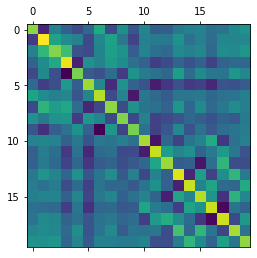

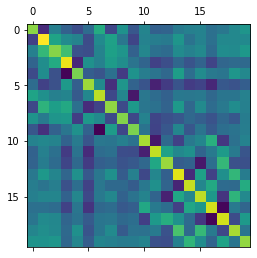

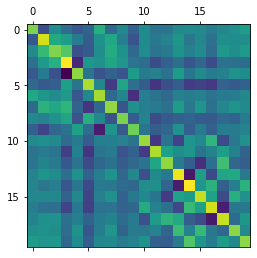

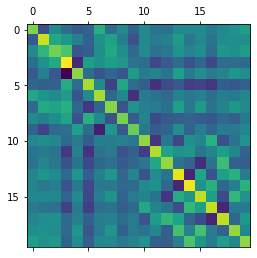

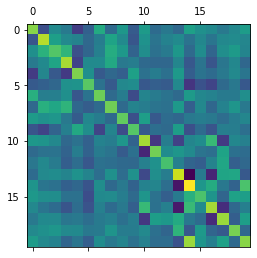

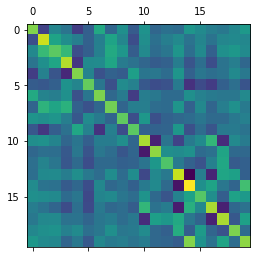

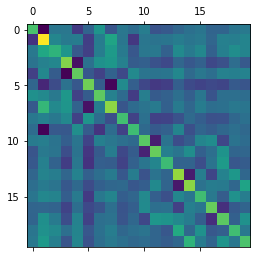

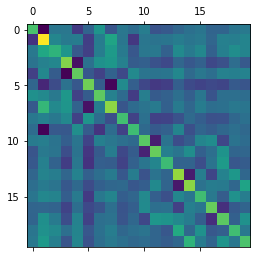

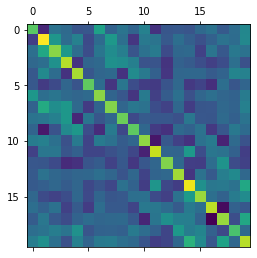

In [9]:

k=10
n = 5
x = x_same[k:k+n]
# y = y_test[k:k+n]

print(y_test[k])

for i, layer in enumerate(model.layers[:-1]): 
    print(layer.name)
    
    aux_model1 = tf.keras.Model(inputs=model.inputs, outputs=layer.output)
    aux_model2 = tf.keras.Model(inputs=model.layers[i+1].input, outputs=model.output)
    jac = [] 
    for i in range(n):

        with tf.GradientTape() as t:
            hidden = aux_model1(x[i:i+1])

            hidden = tf.Variable(hidden)
            logits = aux_model2(hidden) 
            probs = tf.concat((tf.nn.softmax(logits[:, :10]), tf.nn.softmax(logits[:, 10:])), axis=1)
#             print(f'loss: {cce_loss(y[i, 0], logits[:, :10])},  {cce_loss(y[i, 1], logits[:, 10:])}')
#             print(f'probs: {probs.shape}')
        j = t.jacobian(logits, hidden) 

        jac.append(j)

 
    jac = np.array(jac).mean(axis=0)

#     jac = jac.reshape(n, 20, jac.size // (20*n))
    jac = jac.reshape(20, jac.size // 20)

#     print(np.linalg.norm(jac, axis=1))
    M = np.einsum('ij,kj->ik', jac / np.expand_dims(np.linalg.norm(jac, axis=1), axis=1), jac)
#     M = M.mean(axis=0) 
    plt.matshow(M)
#     print([M[i, i] for i in range(20)])


tf.Tensor([0. 6.], shape=(2,), dtype=float32)
conv2d_16
max_pooling2d_13
conv2d_17
max_pooling2d_14
conv2d_18
max_pooling2d_15
conv2d_19
max_pooling2d_16
flatten_4
dense_8
dense_9


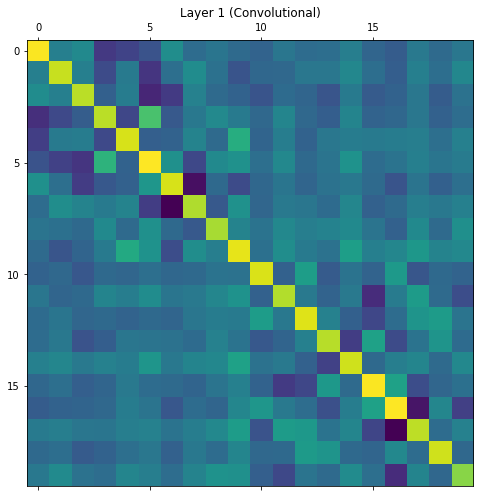

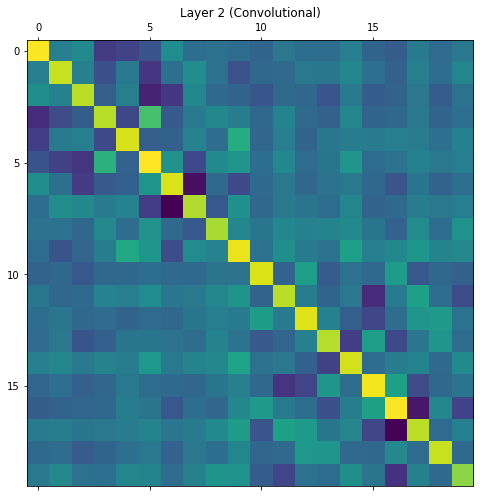

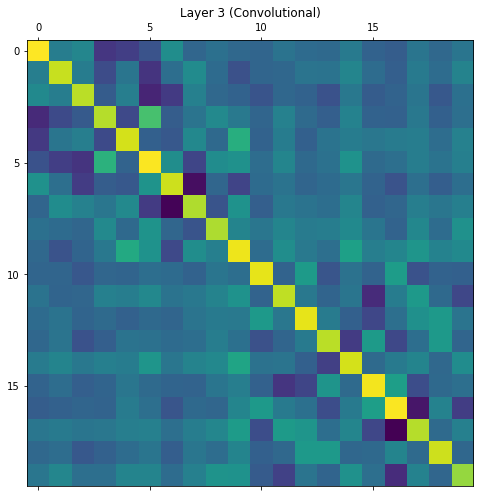

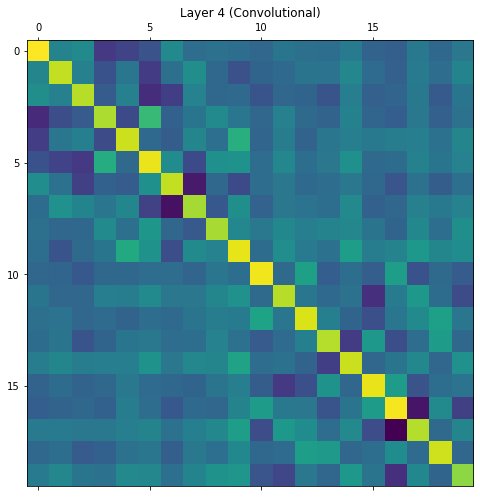

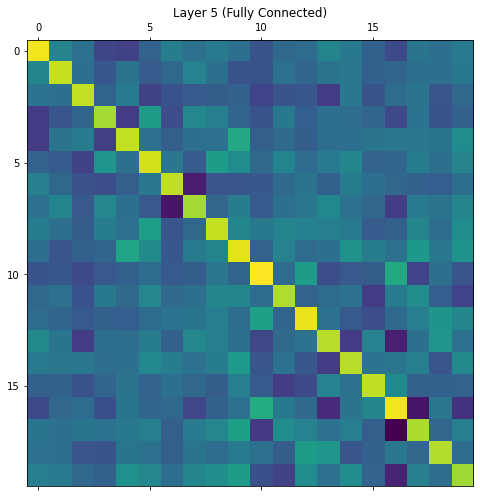

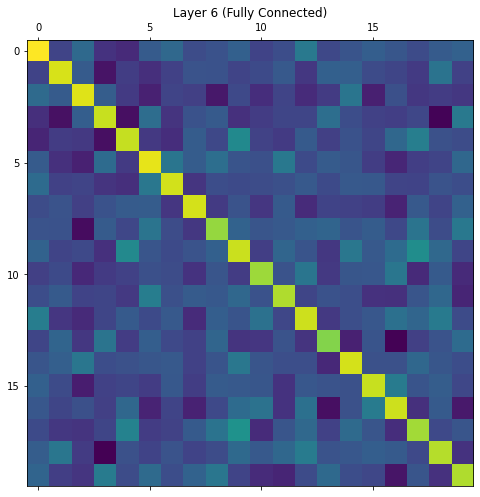

In [44]:

k=10
n = 100
x = x_test[k:k+n]
y = y_test[k:k+n]

print(y_test[k])
layer_idx = 1
for i, layer in enumerate(model.layers): 
    print(layer.name)
    if i == 0:
        aux_model1 = lambda x: x
    else: 
        aux_model1 = tf.keras.Model(inputs=model.inputs, outputs=model.layers[i-1].output)
   
    aux_model2 = tf.keras.Model(inputs=layer.input, outputs=model.output)
    jac = [] 
    for idx in range(n):

        with tf.GradientTape() as t:
            hidden = aux_model1(x[idx:idx+1])

            hidden = tf.Variable(hidden)
            logits = aux_model2(hidden) 
            probs = tf.concat((tf.nn.softmax(logits[:, :10]), tf.nn.softmax(logits[:, 10:])), axis=1)
#             print(f'loss: {cce_loss(y[i, 0], logits[:, :10])},  {cce_loss(y[i, 1], logits[:, 10:])}')
#             print(f'probs: {probs.shape}')
        j = t.jacobian(logits, hidden) 

        jac.append(j)

    
    jac = np.array(jac)

    jac = jac.reshape(n, 20, jac.size // (20*n))
#     jac = jac.reshape(20, jac.size // 20)

#     print(np.linalg.norm(jac, axis=1))
    M = np.einsum('mij,mkj->mik', jac / np.expand_dims(np.linalg.norm(jac, axis=2), axis=2), jac)
    M = M.mean(axis=0) 
    if 'conv' in layer.name: 
        layer_type = "Convolutional"
    else: 
        layer_type = "Fully Connected"
    if layer.weights != []:
        plt.matshow(M)
        plt.title(f'Layer {layer_idx} ({layer_type})')    
        plt.savefig(f'plots/cnn/{layer_type}_{layer_idx}_activation_space.png')
        layer_idx += 1
#     print([M[i, i] for i in range(20)])


2022-07-05 16:52:11.697183: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x89c8670
2022-07-05 16:52:12.115553: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at strided_slice_op.cc:102 : INVALID_ARGUMENT: slice index 3 of dimension 0 out of bounds.


InvalidArgumentError: slice index 3 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

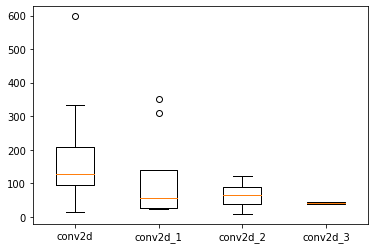

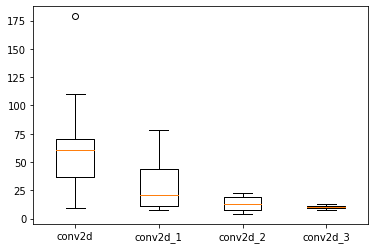

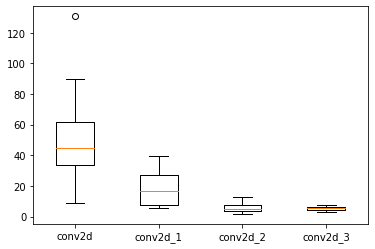

In [10]:
#PCA 

for j in range(5):
    my_dict = {}

    for layer in model.layers:
        if 'conv' in layer.name: 

            aux_model = tf.keras.Model(inputs=model.inputs,
                                       outputs=layer.output)

            # Access both the final and intermediate output of the original model
            # by calling `aux_model.predict()`.

            # we have 6 layers, some principle components, and n data points and n filters. 

            intermediate_layer_output = tf.reduce_mean(aux_model(x_test[:n]), axis=0)
            my_dict[layer.name] = []

    #         print(intermediate_layer_output.shape)

            for i in range(intermediate_layer_output.shape[-1]): 
                s, u, v = tf.linalg.svd(intermediate_layer_output[:, :, i])            
                my_dict[layer.name].append(s[j])



    fig, ax = plt.subplots()
    ax.boxplot(my_dict.values())
    ax.set_xticklabels(my_dict.keys())

In [25]:
n = 500

jac_dict = {}

"""
set up as:
{
  "layer_0": [[derivative vector for point 0 wrt L_d1], [derivative vector for point 0 wrt L_d2], 
  ..., [derivative vector for point n wrt L_d1], [derivative vector for point n wrt L_d2]],
.
.
.
{
  "layer_k": [[derivative vector for point 0 wrt L_d1], [derivative vector for point 0 wrt L_d2], 
  ..., [derivative vector for point n wrt L_d1], [derivative vector for point n wrt L_d2]]
} 
"""


def jacobian_f(weights, layer_name): 
    print(f'layer_name: {layer_name}')
#     print(f'weighst: {weights}')
    for i in tqdm(range(n)): 
        x = x_test[i:i+1]
        y = y_test[i:i+1]
        with tf.GradientTape() as t:
            logits = model(x) 
            cce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
            cce_loss2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

            loss1 = cce_loss(y[:, 0], logits[:, :10]) 
            loss2 = cce_loss2(y[:, 1], logits[:, 10:])
            loss = tf.convert_to_tensor([loss1, loss2])
        jac = t.jacobian(loss, weights)

        
#         print(jac[0].shape)
#         break
     
        jac_dict[name].append(jac[0])

#         if jac1 != None: 
#             print(jac1[0].shape)
#             print(tf.reshape(jac1[0], (-1, jac1[0].shape[-1])).shape)

for layer in model.layers: 
    name = layer.name 
    weights = layer.trainable_weights
    if weights != []:
        jac_dict[name] = []
        jacobian_f(weights, name)

layer_name: conv2d_12


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:41<00:00,  1.46it/s]


layer_name: conv2d_13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:49<00:00,  1.73it/s]


layer_name: conv2d_14


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:54<00:00,  2.14it/s]


layer_name: conv2d_15


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:01<00:00,  2.75it/s]


layer_name: dense_6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:27<00:00,  3.39it/s]


layer_name: dense_7


 24%|█████████████████████████████▊                                                                                            | 122/500 [00:34<01:47,  3.52it/s]


KeyboardInterrupt: 

In [33]:

with open('pickles/jac_dict.pickle', 'wb') as handle:
    pickle.dump(jac_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

# print(a == b)

(500, 2, 3, 3, 1, 64)


/home/thlarsen/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Layer 1 (Convolutional), dist = 1389.899878376903


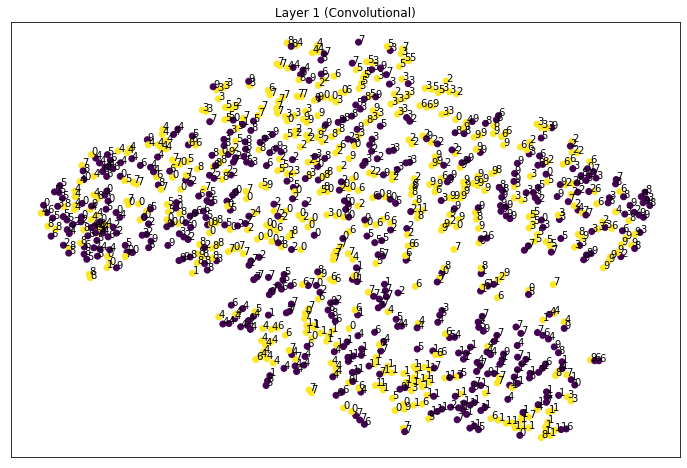

(500, 2, 3, 3, 64, 64)


/home/thlarsen/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Layer 2 (Convolutional), dist = 805.9439749150536


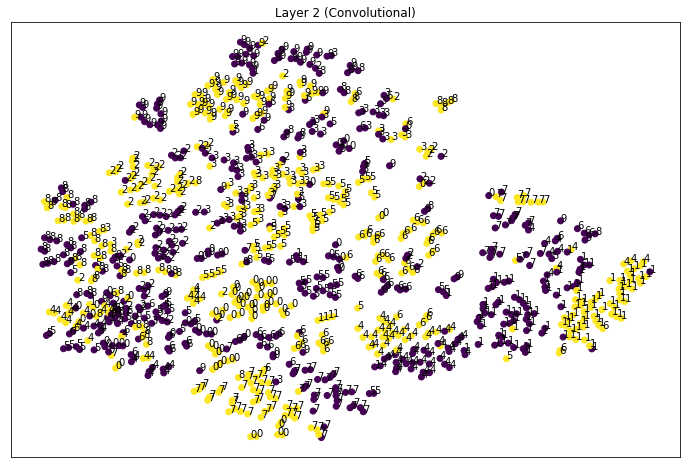

(500, 2, 3, 3, 64, 32)


/home/thlarsen/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Layer 3 (Convolutional), dist = 1098.4159877289994


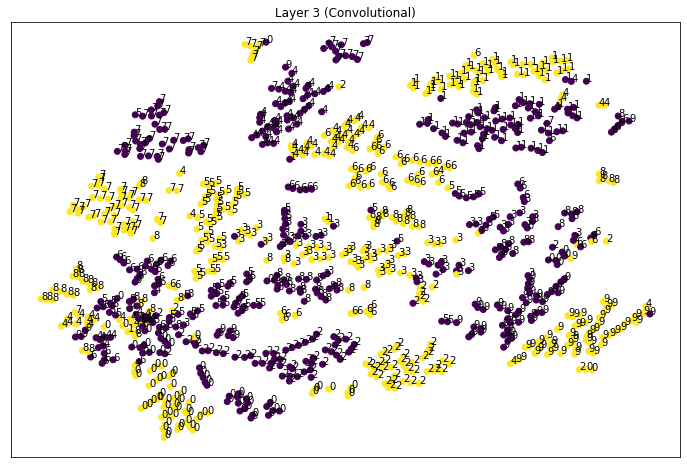

(500, 2, 3, 3, 32, 32)


/home/thlarsen/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Layer 4 (Convolutional), dist = 1245.4514793489916


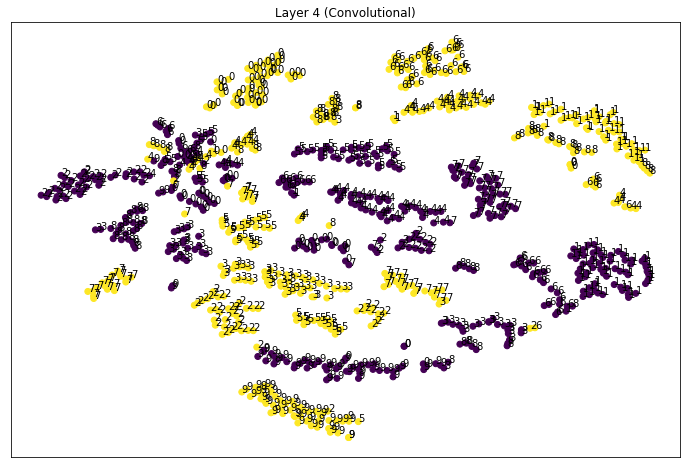

(500, 2, 96, 50)


/home/thlarsen/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Layer 5 (Fully Connected), dist = 1069.813063698843


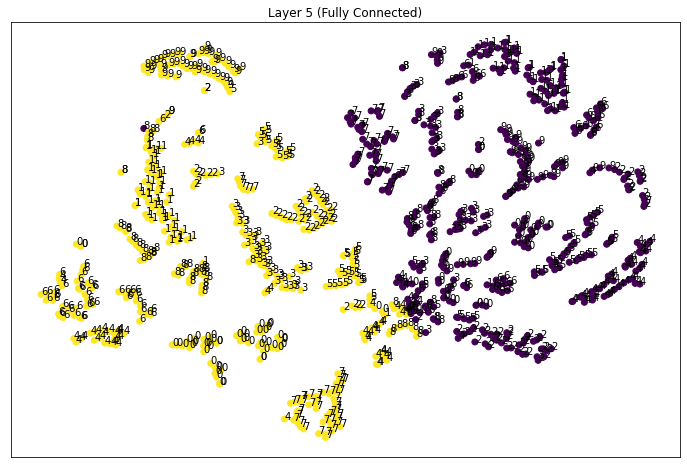

(122, 2, 50, 20)


/home/thlarsen/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Layer 6 (Fully Connected), dist = 128.48033422907497


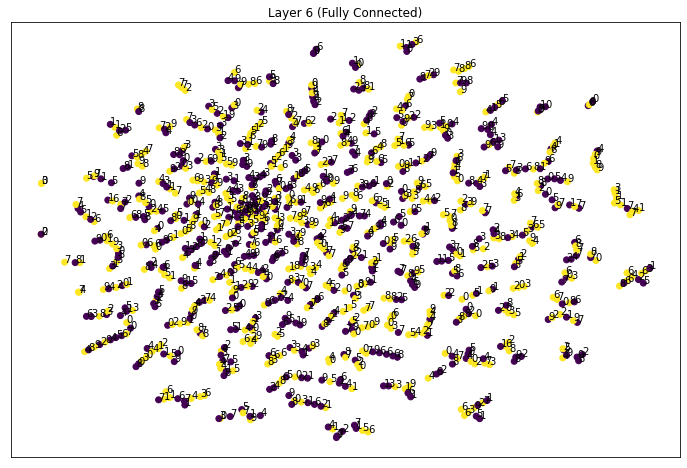

In [35]:
m = n
plt.rcParams['figure.figsize'] = [12, 8]
j = 1

for layer in model.layers: 
    name = layer.name 
    weights = layer.trainable_weights
    if weights != []:
        grads = jac_dict[name]
    #     print(len(grads))
    #     break
        X = np.array([g for g in grads])[:m] 
        dist = 0
        for i in range(X.shape[0]): 
            dist += np.sqrt(np.sum((X[i, 0] - X[i, 1]) ** 2))
#         assert(X.shape[1] == 2)
        print(X.shape)
        X = X * weights[0].numpy()

        X = X.reshape(m, 2, -1)
        X = X.reshape(m*2, -1)

        Y = y_test[:m].numpy().reshape(-1).astype(np.int32)

        X_embedded = TSNE(n_components=2, perplexity=10.0, n_iter = 2000, learning_rate='auto', init='pca').fit_transform(X)
        """
        n_components=2, *, perplexity=30.0, early_exaggeration=12.0, learning_rate='warn', n_iter=1000, 
        n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', metric_params=None, init='warn', 
        verbose=0, random_state=None, method='barnes_hut', angle=0.5, n_jobs=None, square_distances='deprecated') 
        """
       
        labels = [i % 2 for i in range(2*m)]
        plt.figure()
        plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = labels)
#         for i in range(0, len(X_embedded), 2):
#             plt.plot(X_embedded[i:i+2, 0], X_embedded[i:i+2, 1], '-', lw=.4)
        for i in range(X_embedded.shape[0]):
            plt.text(X_embedded[i,0], X_embedded[i,1], str(Y[i]))
        plt.xticks([])
        plt.yticks([])
        if 'conv' in layer.name: 
            layer_type = "Convolutional"
        else: 
            layer_type = "Fully Connected"

        plt.title(f'Layer {j} ({layer_type})')
        print(f'Layer {j} ({layer_type}), dist = {dist}')
        plt.savefig(f'plots/cnn_{str(name)}')
#         plt.legend()
        plt.show()
        j += 1


(100, 2, 3, 3, 1, 16)
conv2d std: 0.13542111217975616,  0.14679233729839325
(100, 2, 3, 3, 16, 8)
conv2d_1 std: 0.012388027273118496,  0.026710404083132744
(100, 2, 3, 3, 8, 4)
conv2d_2 std: 0.028863007202744484,  0.038436125963926315
(100, 2, 3, 3, 4, 2)
conv2d_3 std: 0.06080201640725136,  0.08436641097068787
(100, 2, 42, 20)
dense std: 0.0017075281357392669,  0.0013313516974449158
(100, 2, 20, 20)
dense_1 std: 4.0551597635385406e-09,  1.41189038238565e-09


[Text(1, 0, 'conv2d'),
 Text(2, 0, 'conv2d_1'),
 Text(3, 0, 'conv2d_2'),
 Text(4, 0, 'conv2d_3'),
 Text(5, 0, 'dense'),
 Text(6, 0, 'dense_1')]

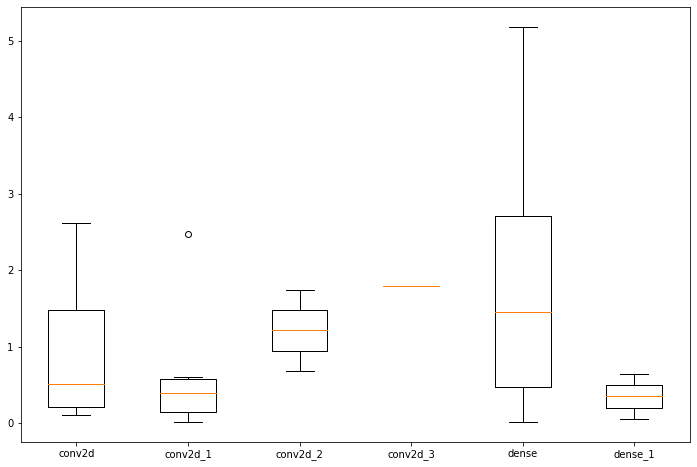

In [13]:
#Average gradient for the output 
my_dict = {}
x_vals = []
y_vals = []

for i, layer in enumerate(model.layers): 
    name = layer.name 
    weights = layer.trainable_weights
    if weights != []:
        grads = jac_dict[name]
    #     print(len(grads))
    #     break
        X = np.array([g for g in grads])[:n] 
#         assert(X.shape[1] == 2)
        print(X.shape)
   
        if 'conv' in name: 
            X = X.mean(axis=(0,2,3,4))
          
        if 'dense' in name: 
            X = X.mean(axis=(0,3))
        
        print(f'{name} std: {np.std(X[0])},  {np.std(X[1])}')
#         my_dict[name] = (X[0] / np.std(X[0])) - (X[1] / np.std(X[1]))
        
        my_dict[name] = []

        for x in (X[0] / np.std(X[0])) - (X[1] / np.std(X[1])): 
            if x > .00001: 
                my_dict[name].append(x)
            
fig, ax = plt.subplots()

# ax.scatter(x_vals, y_vals)
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())

# fig2, ax2 = plt.subplots()
# ax2.boxplot(my_dict2.values())
# ax2.set_xticklabels(my_dict2.keys())

In [ ]:

print(X_h.shape)


---layer: conv2d---

(1, 2, 3, 3, 1, 16)
(1, 3, 3, 1, 16)
num_connected for each loss: [[136 135]]
num_disconnected for each loss: [[8 9]]
percent_connected for each loss: [[0.94444444 0.9375    ]]
percent_connected for both loss: [0.9375]
(1, 2)
(1,)
(1, 3)

---layer: max_pooling2d---


---layer: conv2d_1---

(1, 2, 3, 3, 16, 8)
(1, 3, 3, 16, 8)
num_connected for each loss: [[1074 1072]]
num_disconnected for each loss: [[78 80]]
percent_connected for each loss: [[0.93229167 0.93055556]]
percent_connected for both loss: [0.93055556]
(1, 2)
(1,)
(1, 3)

---layer: max_pooling2d_1---


---layer: conv2d_2---

(1, 2, 3, 3, 8, 4)
(1, 3, 3, 8, 4)
num_connected for each loss: [[247 247]]
num_disconnected for each loss: [[41 41]]
percent_connected for each loss: [[0.85763889 0.85763889]]
percent_connected for both loss: [0.85763889]
(1, 2)
(1,)
(1, 3)

---layer: max_pooling2d_2---


---layer: conv2d_3---

(1, 2, 3, 3, 4, 2)
(1, 3, 3, 4, 2)
num_connected for each loss: [[64 64]]
num_disconnecte

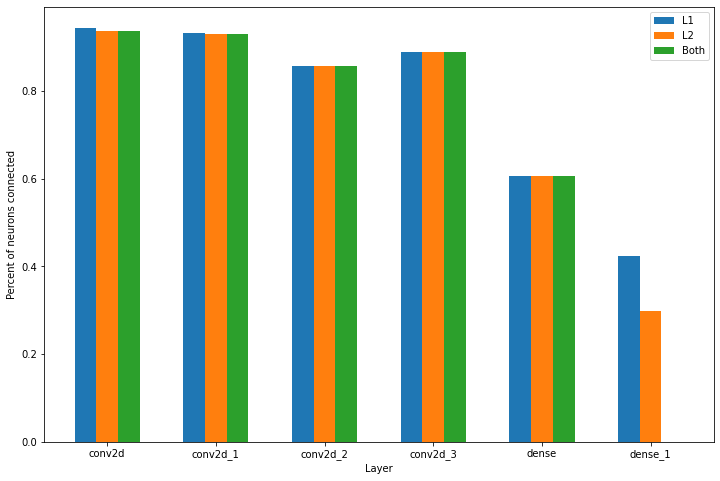

In [14]:
eps = .000000001
# eps = 0
plt.figure() 
layer_names = []
percent_connected_layer = []
for i, layer in enumerate(model.layers): 
    name = layer.name 
    print(f'\n---layer: {name}---\n')
    weights = layer.trainable_weights
    if weights != []:
        grads = jac_dict[name]
    #     print(len(grads))
    #     break
        X = np.array([g for g in grads])[:1] 
        
#         assert(X.shape[1] == 2)
        
        connected = ((-eps < X) & (X < eps)) == 0 
        #things that are not close to 0 are connected. negation of things close to 0
        print(connected.shape)
        connected_both = connected[:, 0] & connected[:, 1] #conected to both losses
        print(connected_both.shape)


        if 'conv' in name: 
            print(f'num_connected for each loss: {connected.sum(axis=(2, 3, 4, 5))}')
            print(f'num_disconnected for each loss: {(connected == 0).sum(axis=(2, 3, 4, 5))}')
            percent_connected = (connected).mean(axis=(2, 3, 4, 5))
            percent_connected_both = (connected_both).mean(axis=(1, 2, 3, 4))

        if 'dense' in name: 
            print(f'num_connected for each loss: {connected.sum(axis=(2, 3,))}')
            print(f'num_disconnected for each loss: {(connected == 0).sum(axis=(2, 3))}')
            percent_connected = (connected).mean(axis=(2, 3))
            percent_connected_both = (connected_both).mean(axis=(1, 2))

        
        print(f'percent_connected for each loss: {percent_connected}')
        print(f'percent_connected for both loss: {percent_connected_both}')

        print(percent_connected.shape)
        print(percent_connected_both.shape)
        temp = np.concatenate((percent_connected, percent_connected_both.reshape((1, 1))), axis=1)
        print(temp.shape)
        percent_connected_layer.append(temp)
        layer_names.append(name)

percent_connected_layer = np.array(percent_connected_layer).reshape(len(layer_names), 3)
print(percent_connected_layer.shape)
X_axis = np.arange(len(layer_names))
print(X_axis.shape)
plt.bar(X_axis - 0.2, percent_connected_layer[:,0], 0.2, label = 'L1')
plt.bar(X_axis + 0, percent_connected_layer[:,1], 0.2, label = 'L2')
plt.bar(X_axis + 0.2, percent_connected_layer[:,2], 0.2, label = 'Both')
 
plt.xticks(X_axis, layer_names)
plt.xlabel("Layer")
plt.ylabel("Percent of neurons connected")
# plt.title("Number of Students in each group")
plt.legend()
plt.savefig('small_cnn_specialization_by_layer.png')
plt.show()

(5, 5, 1, 64)


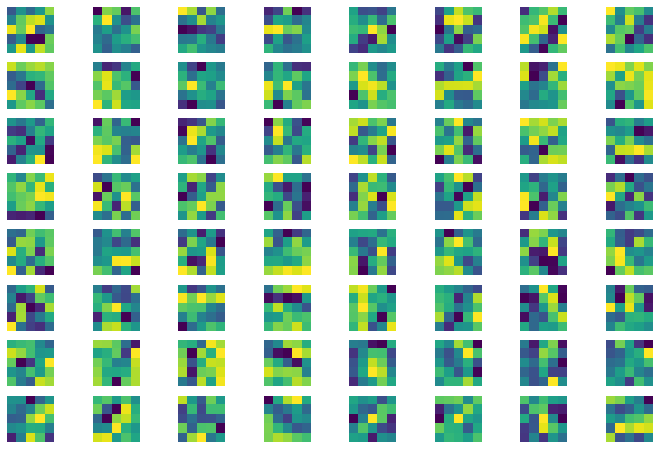

(5, 5, 64, 64)


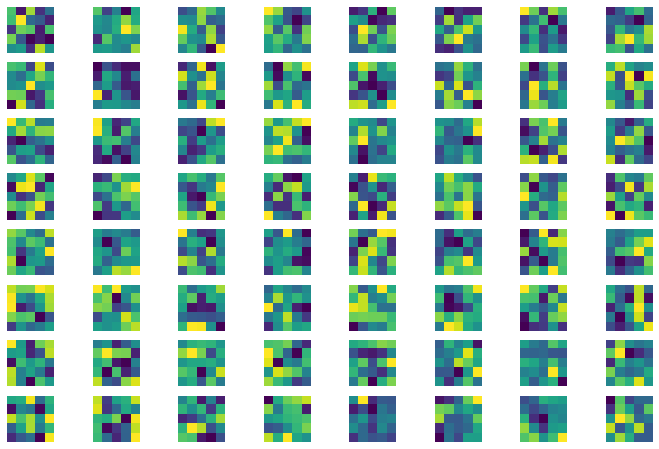

(5, 5, 64, 32)


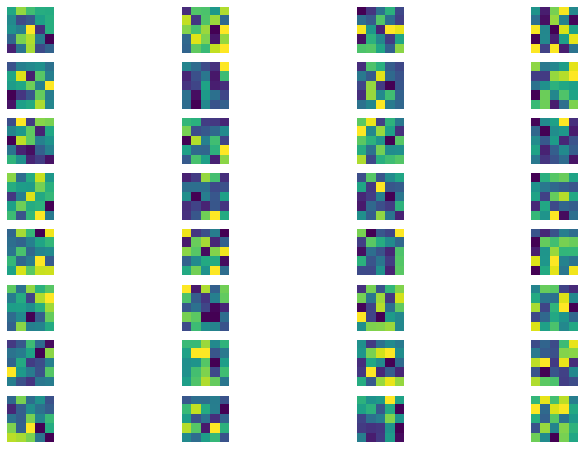

(5, 5, 32, 32)


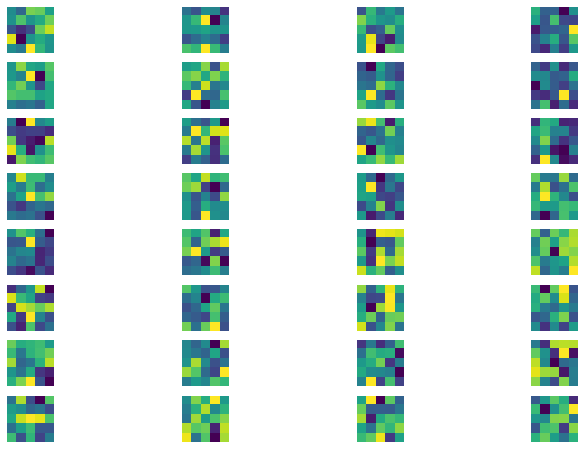

In [20]:

for layer in model.layers: 
    if 'conv' in layer.name: 
        filters, biases = layer.get_weights()
        # normalize filter values to 0-1 so we can visualize them

        print(filters.shape)
        # plot first few filters
        n_filters, ix = filters.shape[-1], filters.shape[-2]
        
        R = 8 
        C = n_filters // R                               
        fig,axes = plt.subplots(R, C)

        for i in range(n_filters):
            # get the filter
            f = filters[:, :, 0, i]
            # plot each channel separately
                # specify subplot and turn of axis
            axes[i % 8, i // 8].set_xticks([])
            axes[i % 8, i // 8].set_yticks([])
            # plot filter channel in grayscale
            axes[i % 8, i // 8].matshow(f[:, :])
            axes[i % 8, i // 8].axis('off')
            ix += 1
        # show the figure
        plt.show()
